# Load data

Load in existing feature and expression datasets. This is the chosen 200 transcripts, along with the 100 PCs.

In [596]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import numpy as np
from limix.plot import qqplot
import warnings
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import gzip
import pandas as pd

mean_features = {}
with h5py.File(GTEx_directory + '/data/intermediate/new_retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    donor_IDs = f['lung']['256']['donor_IDs'].value
    for s in ['128','256','512','1024','2048']:
        size_mean_features = f['lung'][s]['mean'].value
        mean_features[s] = size_mean_features
        
        
    expression_IDs = f['lung']['256']['expression_IDs'].value

most_expressed_transcript_idx, most_varying_feature_idx, results = pickle.load(open(GTEx_directory + '/data/intermediate/retrained_quick_pvalues.py','rb'))

filt_expression = expression[:,most_expressed_transcript_idx]
filt_features = mean_features['256'][:,most_varying_feature_idx]

phenotype_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/PhenotypeFiles/phs000424.v6.pht002743.v6.p1.c1.GTEx_Sample_Attributes.GRU.txt.gz'
with gzip.open(phenotype_filepath, 'rb') as f:
    phenotype_array = [str(x, 'utf-8').split('\t') for x in f.read().splitlines() if not str(x, 'utf-8').startswith('#')][1:]
    phenotype_df = pd.DataFrame(phenotype_array)
    phenotype_df.columns = phenotype_df.iloc[0]
    phenotype_df = phenotype_df[1:]

lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
phenotype_idx = [[x.split('-')[1] for x in lung_df['SAMPID']].index(ID) for ID in [x.decode('utf-8').split('-')[1] for x in donor_IDs]]


lung_df = phenotype_df[phenotype_df['SMTSD'] == 'Lung']
lung_df = lung_df.iloc[phenotype_idx,:]

filt_tech_expression =  filt_expression[technical_idx,:]
filt_tech_features =  filt_features[technical_idx,:]
print ("Filtered technical features:")
print (filt_tech_expression.shape, filt_tech_features.shape)

Filtered technical features:
(231, 200) (231, 100)


This results in 76 covariates for each of the 274 lung samples.

We define our function to again estimate the inflation parameter, $\lambda$.

In [597]:
import scipy.stats as st
import scipy as sp
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return (L)

We take only the samples for which we have technical factors. 

In [598]:
clean_lung_df = pd.DataFrame()
for col in lung_df.columns:
    clean_factor = pd.to_numeric(lung_df[col],errors='coerce')
    clean_lung_df[col] = clean_factor
    

clean_lung_df = clean_lung_df.dropna(how='all',axis=1)
technical_idx = np.array(clean_lung_df.isnull().sum(axis=1) == 0)
clean_lung_df = clean_lung_df.dropna(how='any',axis=0)
raw_technical_covariates = np.array(clean_lung_df)
filter_technical_cov_idx = np.std(raw_technical_covariates,axis=0) < 100
raw_technical_covariates = raw_technical_covariates[:,filter_technical_cov_idx]

This results in a total of 231 samples. We also ensure that we take technical factors with limited variance (< 100), this results in 29 continuous technical factors.

In [599]:
print ("Raw features:")
print (mean_features['256'].shape, expression.shape)
print ("Filtered features:")
print (filt_expression.shape, filt_features.shape)
print ("Technical factors:")
print (raw_technical_covariates.shape)

Raw features:
(274, 1024) (274, 28683)
Filtered features:
(274, 200) (274, 100)
Technical factors:
(231, 29)


Here are the names of the different technical factors we have included. Here are some example descriptions:
* SMATSSCR: Autolysis score
* SMRIN: RNA degradation (RIN) number
* SMTSISCH: Ischemic time

In [578]:
clean_lung_df.columns

Index(['dbGaP_Sample_ID', 'SMATSSCR', 'SMRIN', 'SMUBRID', 'SMTSISCH',
       'SMTSPAX', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT',
       'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH',
       'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT',
       'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR',
       'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF',
       'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH',
       'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART',
       'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

This histogram shows the standard deviations of the technical covariates we have chosen to look at. Note that there are technical factors that still vary a great deal.

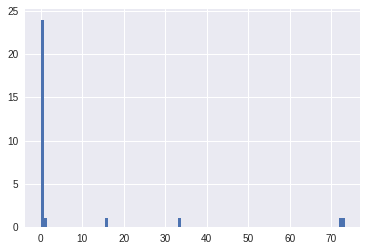

In [580]:
plt.hist(raw_technical_covariates.std(axis=0),bins=100)
plt.show()

Take the first 20 PCs of the expression matrix.

We would like to investigate how including these known technical covariates impact the analysis. 

# Compute feature p-values with lim using 4 different options as the cov parameter.

In [ ]:
pvalue_results = {}

1. No cov parameter
2. 29 technical factors as cov parameter
3. 20 PC components as cov parameter
4. 20 PCs + 29 technical factors as cov parameter

In [600]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

In [678]:
from limix.qtl import qtl_test_lmm
from limix.plot import qqplot

pca_covariates = np.ones((sum(technical_idx),21))
pca_covariates[:,1:] = pca_expression[technical_idx]

technical_pvalues = {}
technical_and_pca_pvalues = {}
raw_pvalues = {}
pca_pvalues = {}

for f in range(100):
    single_feature = filt_tech_features[:,f].copy()
    technical_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=raw_technical_covariates)
    pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=pca_covariates)
    technical_and_pca_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float),covs=np.hstack([pca_covariates, raw_technical_covariates]))
    raw_res = qtl_test_lmm(single_feature, filt_tech_expression.astype(float))
    
    t_pvalues = technical_res.getPv().flatten()
    r_pvalues = raw_res.getPv().flatten()
    tp_pvalues = technical_and_pca_res.getPv().flatten()
    p_pvalues = pca_res.getPv().flatten()

    
    technical_pvalues[f] = t_pvalues
    raw_pvalues[f] = r_pvalues
    pca_pvalues[f] = p_pvalues
    technical_and_pca_pvalues[f] = tp_pvalues
    
    if f % 10 == 0:
        print (f,estimate_lambda(r_pvalues),estimate_lambda(t_pvalues), estimate_lambda(p_pvalues), estimate_lambda(tp_pvalues) )

0 3.73688944142 1.36613025456 1.80748845551 2.44427865077
10 10.7134964061 4.85926910717 1.78892463032 2.2352341152
20 6.50071041449 2.17914364798 2.47411391018 2.32712941172
30 4.73560429028 1.65691255132 2.46887640124 2.72839904426
40 8.62348542576 4.10333518817 1.54183282284 1.54295547312
50 1.55795154534 1.80363968436 1.1368550962 1.44246229062
60 8.95118358183 3.8284880359 2.74818135065 2.66668328236
70 9.35435673122 3.71166452752 1.59707094936 1.75258668597
80 3.26833717286 2.32122236038 2.41168137505 2.83900991922
90 7.507732478 1.78325311987 3.33953467138 2.46586508977


In [682]:
full_technical_pvalues = []
full_technical_and_pca_pvalues = []
full_raw_pvalues = []
full_pca_pvalues = []

for f in range(100):
    full_technical_pvalues.extend(technical_pvalues[f].tolist())
    full_raw_pvalues.extend(raw_pvalues[f].tolist())
    full_pca_pvalues.extend(pca_pvalues[f].tolist())
    full_technical_and_pca_pvalues.extend(technical_and_pca_pvalues[f].tolist())

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


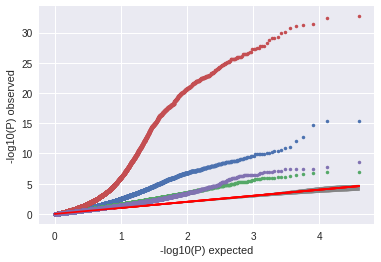

In [683]:
qqplot(np.array(full_technical_pvalues))
qqplot(np.array(full_technical_and_pca_pvalues))
qqplot(np.array(full_raw_pvalues))
qqplot(np.array(full_pca_pvalues))

Calculating p-values using lim with using different covariance sets:
* red - raw. $\lambda = 7.8$
* blue - 29 technical factors. $\lambda = 4.79$
* green - 20 PC componenets. $\lambda = 1.72$
* purple - 20 PCs + 29 technical factors. $\lambda = 1.80$

In [684]:
print (estimate_lambda(np.array(full_raw_pvalues)))
print (estimate_lambda(np.array(full_technical_pvalues)))
print (estimate_lambda(np.array(full_pca_pvalues)))
print (estimate_lambda(np.array(full_technical_and_pca_pvalues)))



4.70935715488
2.57101212194
1.5346561306
1.76903525081


In [681]:
print (sum(smm.multipletests(np.array(full_raw_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_pca_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (sum(smm.multipletests(np.array(full_technical_and_pca_pvalues),method='fdr_bh',alpha=0.01)[0]))


4323
1357
104
77


We can see that the much of the inflation disappears when using the first 20 PCs as covariates. There is not much difference when then including the technical factors.

# How does this change when using different numbers of PCs?

In [606]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)

pca_covariates = np.ones(shape=(len(phenotype_idx),21))
pca_covariates[:,1:] = pca_expression

In [607]:
print (pca_covariates.shape)

(274, 21)


In [608]:
from limix.qtl import qtl_test_lmm
lambdas = []
full_pvalues = {}
for pc in range(20):
    pca_pvalues = {}

    for f in range(100):
        single_feature = filt_features[:,f].copy()
        
        pca_res = qtl_test_lmm(single_feature, filt_expression.astype(float),covs=pca_covariates[:,:pc+2])
        p_pvalues = pca_res.getPv().flatten()
        pca_pvalues[f] = p_pvalues


    full_pca_pvalues = []
    for f in range(100):
        full_pca_pvalues.extend(pca_pvalues[f].tolist())
    lamb = estimate_lambda(full_pca_pvalues)
    lambdas.append(lamb)
    full_pvalues[pc] = full_pca_pvalues 
    print (pc,lamb)

0 2.61011822323
1 2.45640707069
2 2.35283520603
3 1.72723805151
4 1.76075013684
5 1.65674416009
6 1.67749756037
7 1.72823053394
8 1.68459614238
9 1.71881789142
10 1.60821788616
11 1.63787424924
12 1.53902719261
13 1.53092602898
14 1.50275431314
15 1.47314213856
16 1.48789357744
17 1.4380809707
18 1.47569962002
19 1.51882083761


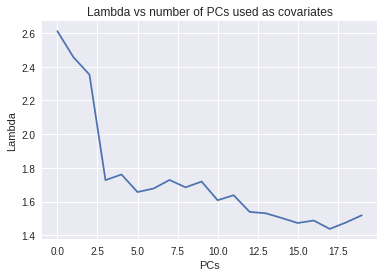

In [610]:
plt.plot(lambdas)
plt.title("Lambda vs number of PCs used as covariates")
plt.xlabel("PCs")
plt.ylabel("Lambda")

There seems to be a minimum at 20 PCs with lambda ~ 1.

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


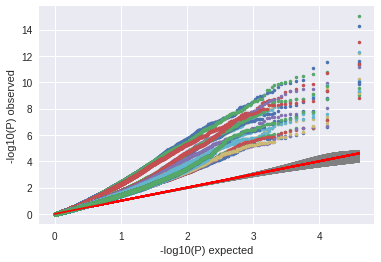

In [611]:
for pc in range(20):
    qqplot(np.array(full_pvalues[pc]))

# Feature p-values after regressing out known technical and PC factors

Here, we look for the associations with the residuals after regressing the effect of including the first $k$ PCs.

I.e. we first train the linear model:
    
$$y = X\beta + \epsilon$$

with $y$ as one of our image phenotypes and $X$ set as the first $k$ PCs. We then consider the residuals:

$$\epsilon = y - X\beta $$

We treat this as new phenotypes.

and we train another linear model:

$$\epsilon = X'\beta' + \epsilon'$$

With $X'$ being the expression value of a single sample.

We extend the sklearn LinearRegression class to return both the p-value and the standard error.

In [612]:
from sklearn import linear_model
from scipy import stats
import numpy as np
import pdb


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self).__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])

        se = np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

Compute the first 50 PCs of the expression matrix.

In [613]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_expression = pca.fit_transform(expression)
filt_pca_expression = pca_expression[technical_idx]

In [614]:
X = np.ones(shape=(raw_technical_covariates.shape[0],filt_pca_expression.shape[1] + raw_technical_covariates.shape[1] + 1))
X[:,1:filt_pca_expression.shape[1] + 1] = filt_pca_expression
X[:, 21:] = raw_technical_covariates


Using first 4 PCs, what does the QQ plot look like?

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


29
1.25397227527


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


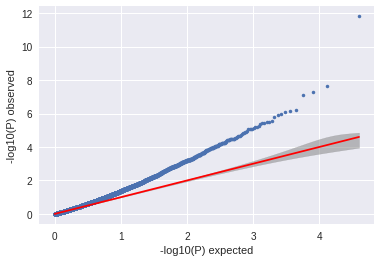

In [686]:
full_pvalues = {}
for f in range(100):
    
    lr = LinearRegression()
    res = lr.fit(X[:,:4],filt_tech_features[:,f])
    eps = res.predict(X[:,:4]) - filt_tech_features[:,f]

    residual_lr = LinearRegression()

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_pc_full_pvalues = []
for f in range(100):
    all_pc_full_pvalues.extend(full_pvalues[f])
    

print (sum(smm.multipletests(np.array(all_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_pc_full_pvalues)))
qqplot(np.array(all_pc_full_pvalues))

What do the top associations look like?

In [617]:
def get_t_f_idx(position):
    f = int(np.floor(position / 200))
    t = position % 200
    return f,t

def display_scatter(f,t,axis=None):
    R, pv = pearsonr(filt_features[:,f], filt_expression[:,t])
    if axis:
        axis.scatter(filt_features[:,f], filt_expression[:,t])
        axis.set_title("R: {:0.2} pv: {:0.2}".format(R,pv))
    else:
        plt.scatter(filt_features[:,f], filt_expression[:,t])
    return R, pv

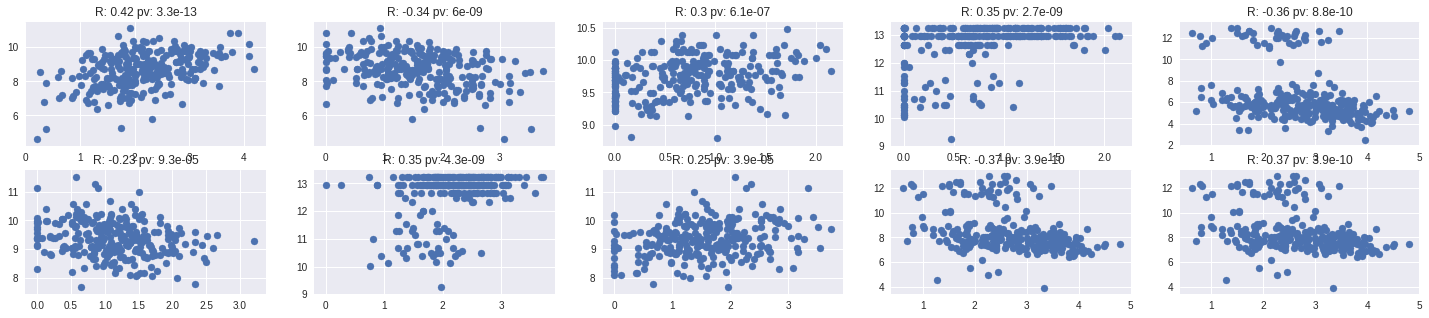

In [618]:
sorted_idx = np.argsort(np.array(all_full_pvalues))
f,a = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    display_scatter(f,t,a.flatten()[i])

There seems to be signal in the residuals, even when regressing out the effects of the first 9 PCs.

How does the inflation depend on the number of PCs used?

In [619]:
pc_pvalues = {}
pc_lambdas = []
for pc in range(20):
    print (pc)
    feature_pvalues = {}
    for f in range(100):
        
        residual_lr = LinearRegression()
        res = residual_lr.fit(X[:,:pc+1],filt_tech_features[:,f])
        eps = res.predict(X[:,:pc+1]) - filt_tech_features[:,f]
        
        
        pvalues = []
        for i in range(200):
            pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
            pvalues.append(pvalue)
            
        feature_pvalues[f] = pvalues
        
        

        all_full_pvalues = []
    for f in range(100):
        all_full_pvalues.extend(feature_pvalues[f])

    pc_lambdas.append(estimate_lambda(np.array(all_full_pvalues)))
    pc_pvalues[pc] = all_full_pvalues 

0


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in absolute
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


1


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Looking for associations with the residuals after regression out first x PCs

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


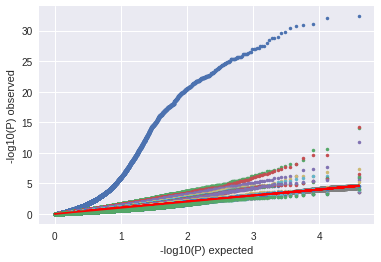

In [620]:
for pc in range(20):
    qqplot(np.array(pc_pvalues[pc]))

QQ plots of association with residuals after regressing a the first for x PCs. x varys from 0 to 28. Each colour represents a different PC.

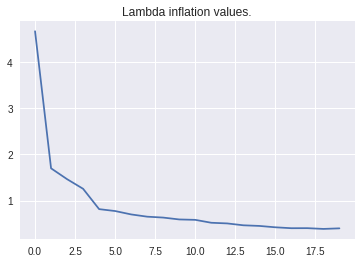

In [622]:
plt.title("Lambda inflation values.")
plt.plot(pc_lambdas)

Lambda as a function of number of PCs used.

# We can repeat this, but instead look at the technical factors.

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

52
1.63274481423


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


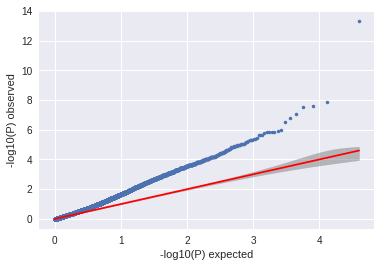

In [689]:
full_pvalues = {}
for f in range(100):    
    lr = LinearRegression()
    res = lr.fit(X[:,21:],filt_tech_features[:,f])
    eps = res.predict(X[:,21:]) - filt_tech_features[:,f]

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_tech_full_pvalues = []
for f in range(100):
    all_tech_full_pvalues.extend(full_pvalues[f])

print (sum(smm.multipletests(np.array(all_tech_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_tech_full_pvalues)))
qqplot(np.array(all_tech_full_pvalues))

What do the top associations look like?

48 121
50 115
27 121
10 121
75 121
88 73
59 121
6 121
88 49
81 121


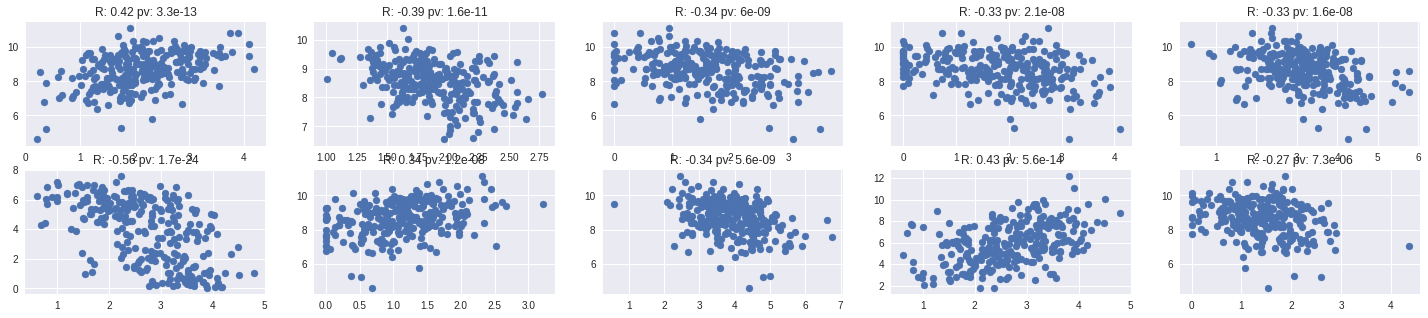

In [626]:
sorted_idx = np.argsort(np.array(all_full_pvalues))
fig,axis = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f,t)
    display_scatter(f,t,axis.flatten()[i])

# Using first 3 PCs and technical factors as covariates

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: inval

7
0.984216778659


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


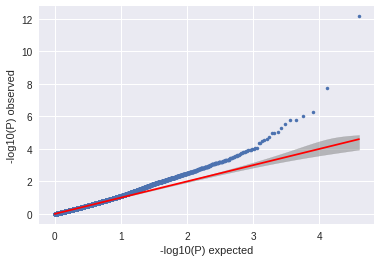

In [716]:
full_pvalues = {}
for f in range(100):    
    lr = LinearRegression()
    res = lr.fit(np.hstack([X[:,:3], X[:,21:]]),filt_tech_features[:,f])
    eps = res.predict(np.hstack([X[:,:3], X[:,21:]])) - filt_tech_features[:,f]

    feature_pvalues = []
    for i in range(200):
        pvalue = pearsonr(filt_tech_expression[:,i],eps)[1]
        feature_pvalues.append(pvalue)
    full_pvalues[f] = feature_pvalues

all_tech_and_pc_full_pvalues = []
for f in range(100):
    all_tech_and_pc_full_pvalues.extend(full_pvalues[f])

print (sum(smm.multipletests(np.array(all_tech_and_pc_full_pvalues),method='fdr_bh',alpha=0.01)[0]))
print (estimate_lambda(np.array(all_tech_and_pc_full_pvalues)))
qqplot(np.array(all_tech_and_pc_full_pvalues))

In [731]:
from pyensembl import EnsemblRelease

import pdb
data = EnsemblRelease(77)

def get_gene_name(transcript):
    transcript_id = transcript.decode('utf-8').split('.')[0]
    return data.gene_name_of_gene_id(transcript_id)


In [ ]:
most_expressed_transcript_idx][t]

(231, 200)

48 121
10 121
50 115
27 121
13 121
57 121
84 121
75 121
20 121
50 128


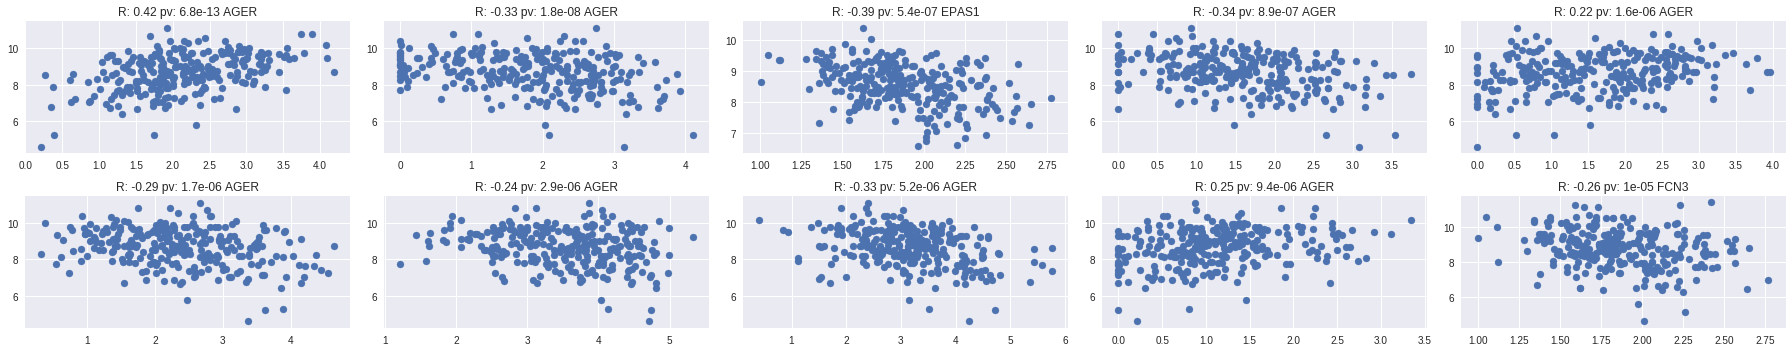

In [732]:
sorted_idx = np.argsort(np.array(all_tech_and_pc_full_pvalues))
fig,axis = plt.subplots(2,5,figsize=(25,5))
for i in range(10):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f,t)
    axis.flatten()[i].scatter(filt_features[:,f], filt_expression[:,t])
    pv = np.array(all_tech_and_pc_full_pvalues)[sorted_idx][i]
    R = pearsonr(filt_features[:,f], filt_expression[:,t])[0]
    transcript_name = get_gene_name(expression_IDs[most_expressed_transcript_idx][t])
    axis.flatten()[i].set_title("R: {:0.2} pv: {:0.2} {}".format(R,pv,transcript_name))
plt.tight_layout()

# P-values using the expression matrix as G

Here we used the entire gene expression matrix as a kinship matrix. In theory, the would account for much of the inflation because transcripts that covary strongly due to a technical factor would have high kinship similarity.

0.570737588507


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


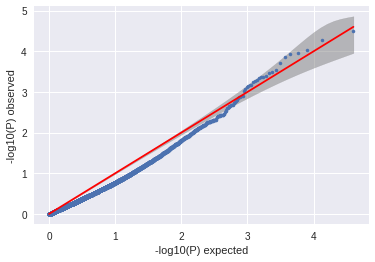

In [672]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

G = filt_tech_expression.copy()
K = corr2_coeff(G,G)

all_full_pvalues = []
for f in range(100):
    res = qtl_test_lmm(filt_tech_features[:,f], filt_tech_expression.astype(float),K=K.astype(float))
    pvalues = res.getPv()
    all_full_pvalues.extend(pvalues)
    

print (estimate_lambda(np.array(all_full_pvalues).flatten()))
qqplot(np.array(all_full_pvalues).flatten())

What do the top associations look like?

70 126
35 149
71 126
93 126
48 126


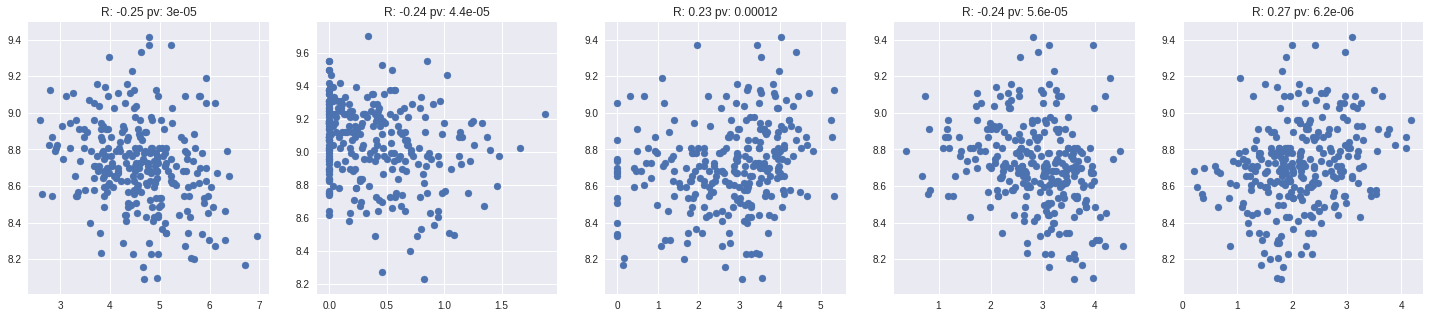

In [633]:
sorted_idx = np.argsort(np.array(all_full_pvalues).flatten())
fig,ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    position = sorted_idx[i]
    f, t = get_t_f_idx(position)
    print (f, t)
    display_scatter(f,t,ax[i])

Notes from meeting with Leo

Take PCs after taking residuals.

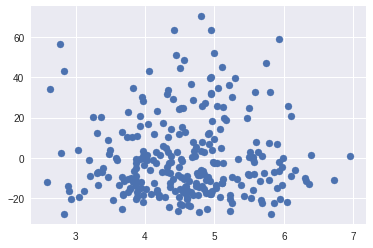

In [635]:
plt.scatter(filt_features[:,70],pca_expression[:,2])

In [644]:
max(np.array([pearsonr(filt_tech_expression[:,121], clean_lung_df[col])[0] for col in clean_lung_df.columns]))

/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


0.15877576371460214

In [659]:
sum(smm.multipletests(results['mean_256_pvalues'].flatten(),method='fdr_bh',alpha=0.01)[0])

4710

# Outline

**Introduction**

Genetic association studies require well-defined phenotypes. Constructing precise features is difficult in image data, so what is the best approach when analysing the GTEx high-resolution histopathology images and bulk gene expression data? We explore this question by exploiting neural networks, known for their ability to construct high-level discriminatory features between classes.


**Tissue prediction**

 Specifically, we modified InceptionNet-v3, a 220-layer Convolutional Neural Network pre-trained to distinguish everyday objects in images, to classify tissue types from image patches. To do so, we added 1024 fully-connected neurons to the final layer, and fine-tuned the network on 50 image patches from 100 images of 10 tissues. We vary the size of the sampled patches, rescaling all patches to be 299x299 pixels. We achieved 81% accuracy on held-out test data when using 128x128 patches in training and classification, and 94% when using 4096x4096 image patches, demonstrating that neural networks trained on general tasks can be repurposed for accurate biological image analysis.
 
Next, we asked whether the neural network extracted high-level features. We used the average 1024 final layer neuron outputs calculated from all non-overlapping 128x128 pixel patches from each lung image excluding the background as quantitative traits, and tested for their association with gene expression levels using the linear mixed model framework implemented in Limix. 


**Expression association**

Across 274 lung samples, we aggregated the features from all 256x256 patches whose center covers a non-whitespace area of the tissue. This boundary was defined using Otsu thresholding. For each sample, this resulted in a vector of length 1024 representing the aggregated image features extract from the retrained neural network.

We first investigate the distribution of these aggregated features. We found that the majority of these features were 0 across all samples, but some showed wide variability between samples. These image features were designed to differentiate between tissue types, so what causes this variation?

We choose to investigate the top hundred varying transcripts, along with the 100 transcripts with highest mean expression, along with the 100 transcript with largest standard deviation. This selection was taking into account the variation for all patch-sizes. We test linear-correlation between each aggregated feature, transcript pair.

We find large numbers of statistically significant genes across all patch-sizes. For example, patch size of 256 pixels we find 4710 statistically significant associations. (BH alpha < 0.01). We find that the greatest number of associations occurs at a patch-size of 256. We found that aggregating over the mean results in a greater number of associations than when aggregating over the median for all patches sizes. We find a greater number of associations after fine-tuning Inceptionet, for a patch-size of 256, but a greater number of associations with raw Inceptionet when using patch sizes greater than this.

We found these p-values to be highly inflated (lambda = 4.71), suggesting factors of variation affecting large groups of transcripts.

We assess how much variation is a cause of technical factors. We extract 51 technical factors that describe sample conditions.  Some technical factor displayed extreme variation, therefore were discluded these. We take the technical factors with standard devation < 100. This results in 29 technical factors. Examples include: RNA degradation (RIN) number, Exonic/Intronic mapping rates, and ischmeic time. We also investigate including $k$ the first principle components as covariates. We used the $\lambda$ inflation parameter to assess p-value inflation.

We compare 3 models to disclude technical variation.
* The first is to include them as a covariance parameter in linear mixed model (LMM), limix []. First, we did not include any technical covariates. This resulted in an inflation parameter of 4.71, and found 4323 significant associations (BH alpha=0.01). We found that including these 29 factors reduced the inflation to 2.57, and 1375 significant associations (BH alpha=0.01). We found that including the first 5 PCs reduced to inflation 1.57, and 107 significant associations (BH alpha=0.01). We found that including the first 5 PCs and the technical factors resulted in an inflation parameter of 1.71, and 77 significant associations (BH alpha=0.01).
* The second was to compute the associations with the residuals after regressing out known variation. Regressing out the technical factors resulted in $\lambda$ = 1.63, and 29 significant associations (BG alpha = 0.01).  Regressing out the first 3 principle components resulted in $\lambda$ = 1.25, and 52 significant associations (BG alpha = 0.01). Including any more principle components resulted in a negative lambda value. Including both the technical factors and first 3 PCs resulted in a lambda of 0.85 and 2 significant associations (BG alpha = 0.01). Including both the technical factors and first 2 PCs resulted in a lambda of 0.98 and 7 significant associations (BG alpha = 0.01).
* The third was to include the cross-correlation matrix computed from the expression matrix as a kinship matrix. This resulted in severely underinflated p-values with inflation parameter = 0.57.

We assessed that correcting for known variation regressing out the technical variation and 2 PCs resulting in appropriate levels of inflation. For lung with patch-size of 256, we found the levels of expression from transcripts with gene IDs AGER, FCN3, and EPAS1 show a strong relation to the aggregated levels of many image features. It has not yet been reported in the literature that the levels of these genes give a visual effect. These transcripts did not display any correlation to known technical factors.

Still to do:
* Feature interpretation
* Repeat across different tissues + feature layers, aggregate genotypes.
* Look for genotype associations
* Integrate clinical factors



In [750]:
for col in clean_lung_df.columns:
    print (pearsonr(expression[:,most_expressed_transcript_idx][technical_idx][:,128], clean_lung_df[col]))

(0.056189888727762288, 0.3952965273379011)
(-0.13039236659759096, 0.047759656470198718)
(-0.032617229597555253, 0.62188473460170735)
(nan, 1.0)
(-0.088161947063557511, 0.18178532815754173)
(-0.050315816386149098, 0.4466165066046438)
(-0.04848679273649132, 0.46333326892404048)
(-0.060480872821296681, 0.36014906327233021)
(0.086634505410646392, 0.18950132957330348)
(0.1034139560468833, 0.11701304658210923)
(-0.050516372330802202, 0.44480446139982566)
(0.13691722081407962, 0.037573634739991875)
(-0.016156929470265147, 0.80703884486288557)
(-0.17466763728919274, 0.0077954669230112803)
(-0.012593954944980298, 0.84901079757289399)
(0.073059395260392693, 0.26878647953572726)
(nan, 1.0)
(-0.027181756611802124, 0.68110057333190277)
(0.015739276553491437, 0.81193279791536699)
(-0.072453575935667577, 0.27278688757566516)
(-0.083272279850947359, 0.20732524048343751)
(-0.060871562751903543, 0.35704874872058834)
(-0.085198069427450354, 0.19697387845575118)
(-0.0828434231426812, 0.20968283395752987)


/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Look at technical PCs, images features PCs. 

Decomposed the variation into 